In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import requests

import pandas as pd
import random
import numpy as np

covid_path = os.path.join('/content','drive','My Drive','covid')


In [0]:
rilevazioni = pd.read_csv('/content/drive/My Drive/IT/Python/covid/rilevazioni.csv').set_index(['Regione','Citta'])
rilevazioni

08-03  09-03  10-03  ...  28-03  29-03  30-03
Regione   Citta                                 ...                     
LOMBARDIA BERGAMO            997   1245   1472  ...   8349   8527   8664
          BRESCIA            501    739    790  ...   7678   8013   8213
          COMO                27     40     46  ...    903   1014   1061
          CREMONA            665    916    957  ...   3605   3762   3788
          LECCO               53     66     89  ...   1316   1381   1437
...                          ...    ...    ...  ...    ...    ...    ...
CALABRIA  COSENZA              1      4      6  ...    154    171    184
          REGGIO CALABRIA      1      2      3  ...    155    189    190
          CATANZARO            2      3      3  ...    118    123    134
          VIBO VALENTIA        0      2      1  ...     39     39     44
          CROTONE              0      0      0  ...     87     90     93

[108 rows x 23 columns]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

def plot_annotate(df, xdelta=0, ydelta=10, figsize=(15, 7)):
  
  ax = df.T.plot(figsize=figsize)
  ax.set_xticks(ticks=np.arange(0, len(df.columns), step=1))
  ax.set_xticklabels(list(df.columns))

  for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
    for el in v[1]:
      ax.annotate(el, (k + xdelta, el + ydelta))
  return ax

In [0]:
sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]

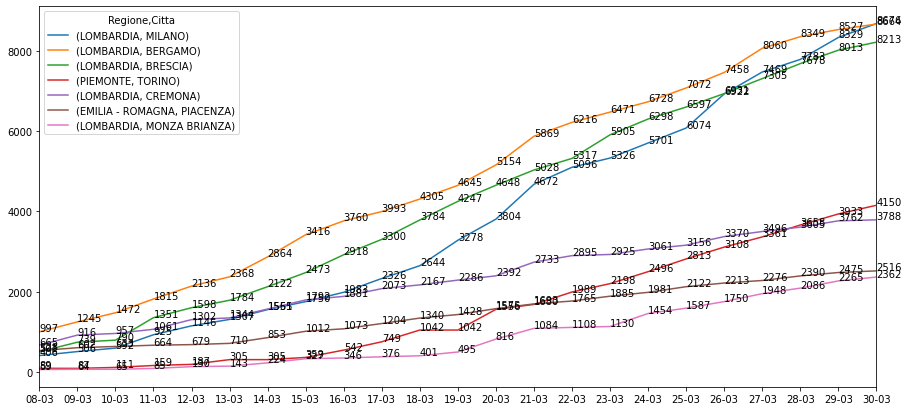

In [0]:
_ = plot_annotate(sorted_by_infections.head(7))

In [0]:
crescita = pd.DataFrame(index=sorted_by_infections.index)

In [0]:
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]

In [0]:
display(crescita.head(3))
sorted_by_infections.head(3)

09-03  10-03  11-03  12-03  ...  27-03  28-03  29-03  30-03
Regione   Citta                                ...                            
LOMBARDIA MILANO     100     86    333    221  ...    547    314    546    347
          BERGAMO    248    227    343    321  ...    602    289    178    137
          BRESCIA    238     51    561    247  ...    374    373    335    200

[3 rows x 22 columns]

08-03  09-03  10-03  11-03  ...  27-03  28-03  29-03  30-03
Regione   Citta                                ...                            
LOMBARDIA MILANO     406    506    592    925  ...   7469   7783   8329   8676
          BERGAMO    997   1245   1472   1815  ...   8060   8349   8527   8664
          BRESCIA    501    739    790   1351  ...   7305   7678   8013   8213

[3 rows x 23 columns]

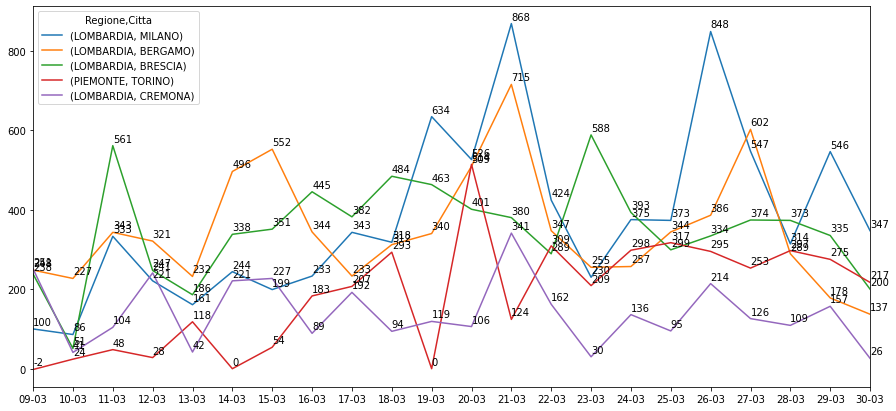

In [0]:
_ = plot_annotate(crescita.head(5))

In [0]:
#display(crescita.loc[('EMILIA - ROMAGNA','PARMA'),:])
#sortedd_by_infections.loc(('EMILIA - ROMAGNA','PARMA'))

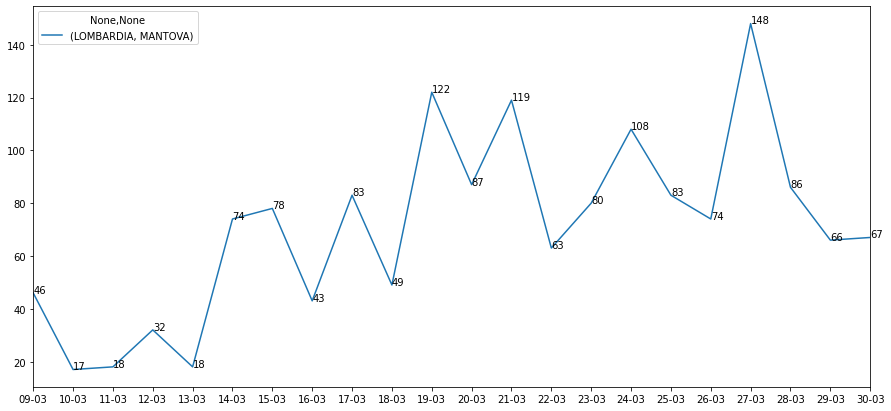

In [0]:
plot_annotate(crescita.loc[('LOMBARDIA','MANTOVA')].to_frame().T, ydelta=0)

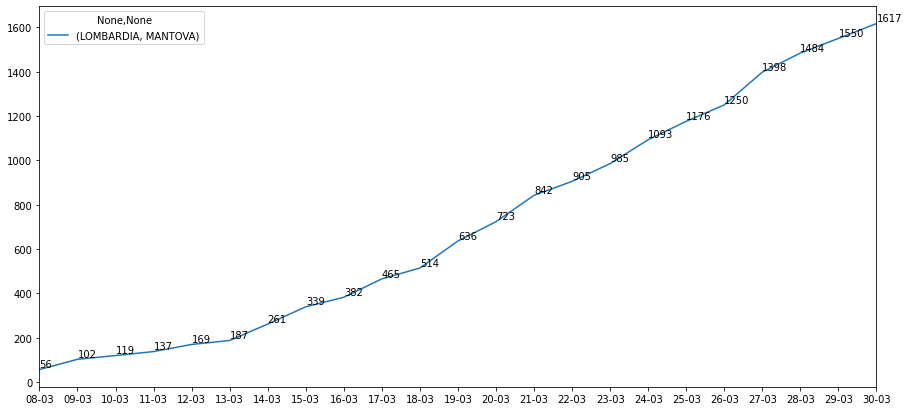

In [0]:
_ = plot_annotate(sorted_by_infections.loc[('LOMBARDIA','MANTOVA')].to_frame().T)

# Average 3 days

In [0]:
avg3 = pd.DataFrame(index=sorted_by_infections.index)
for meno2,ieri, oggi in zip(crescita.columns[:-2], crescita.columns[1:-1], crescita.columns[2:]):
  avg3[oggi] = pd.concat([crescita[oggi], crescita[ieri], crescita[meno2]], axis=1).mean(axis=1)

In [0]:
avg3 = avg3.astype('int32')

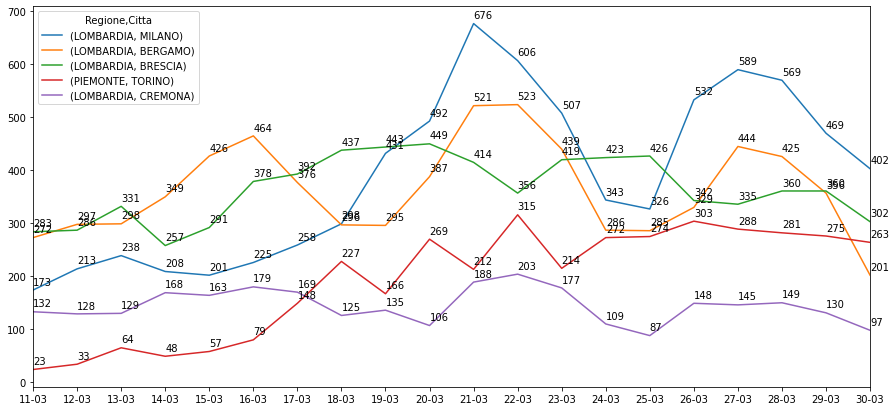

In [0]:
_ = plot_annotate(avg3.head(5))

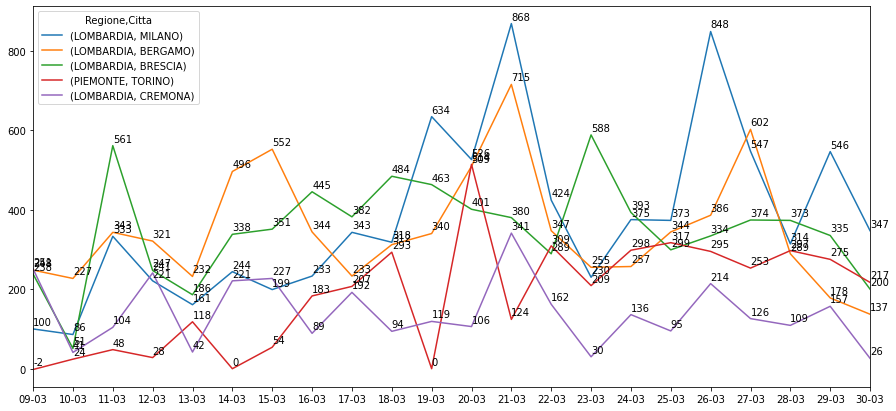

In [0]:
_ = plot_annotate(crescita.head(5))